## Exploratory Data Analysis on MS-COCO style datasets

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
import os
from pycocotools.coco import COCO
from skimage import io
from config import CATEGORIES_WITH_BACKGROUND

font = {'family': 'Arial',
        'weight': 'normal',
        'size': 12}

matplotlib.rc('font', **font)

## Setting the root directory and annotation json file

In [2]:
CLASSES = CATEGORIES_WITH_BACKGROUND

src_file = r"D:\datasets\tw_rpc\combine\val_syn3000.json"
src_desc = r"D:\datasets\tw_rpc\combine\val_syn3000"  # a name (identifier) for the dataset

coco_obj = COCO(src_file)
# Reading the json file
with open(src_file, 'r') as f:
    root = json.load(f)

root.keys()

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


dict_keys(['categories', 'images', 'annotations'])

## Basic High Level Information

In [3]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]

print('Dataset Name: ', src_desc)
print('Number of images: ', n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights) / len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths) / len(widths)))

Dataset Name:  D:\datasets\tw_rpc\combine\val_syn3000
Number of images:  3044
Number of bounding boxes:  17263
Number of classes:  10
Max min avg height:  3024 3024 3024
Max min avg width:  3024 3024 3024


## Distribution of objects across images

In [4]:
# Objects per image distribution

img2nboxes = {}  # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']

    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list) / len(nboxes_list))

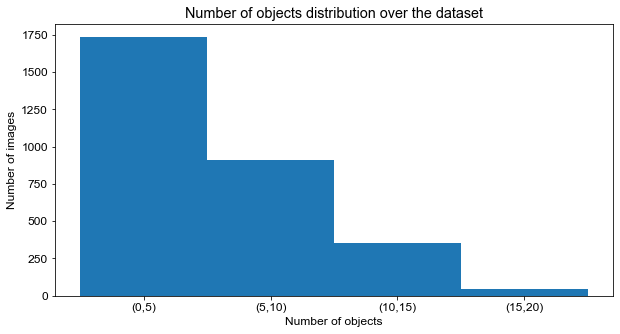

Number of images having atleast one box:  3044
Min number of boxes per image:  1
Max number of boxes per image:  18
Avg number of boxes per image:  5


In [5]:
out = pd.cut(nboxes_list, bins=np.arange(0, max_nboxes + 5, 5), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left), int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels]
ticks = ['(' + str(i[0]) + ',' + str(i[1]) + ')' for i in labels]

plt.figure(figsize=(10, 5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

## Class wise distribution of objects

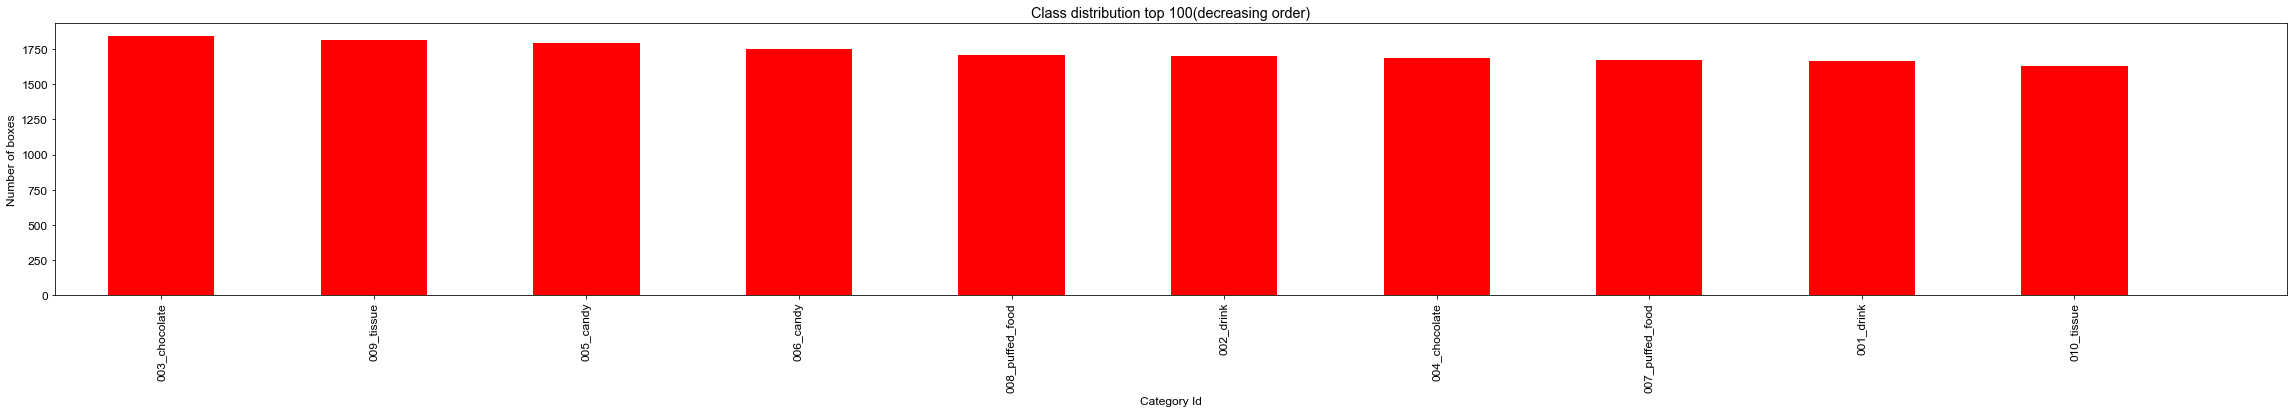

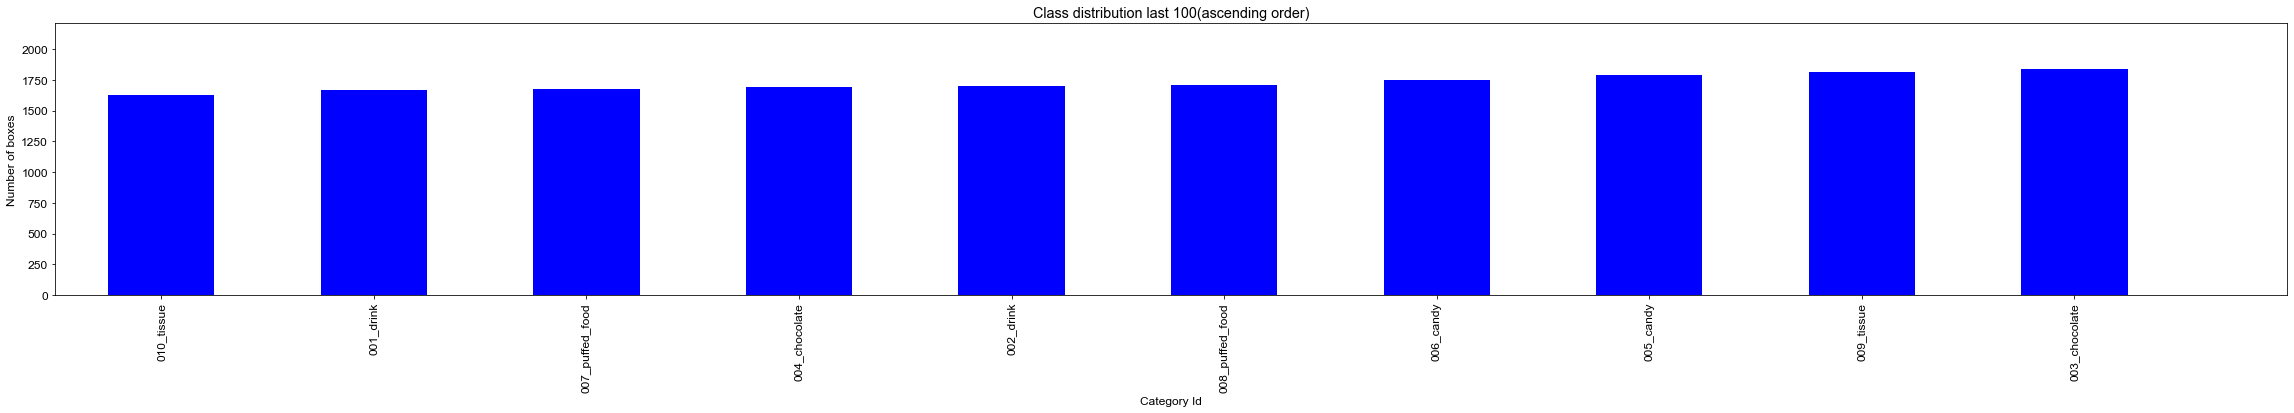

In [6]:
# Class distribution 將各類別出現的數量(bbox數)排序出來
class2nboxes = {}
nboxes_list_by_catID = [0] * 201
for ann in root['annotations']:
    cat_id = ann['category_id']
    nboxes_list_by_catID[cat_id] += 1
    if CLASSES[cat_id] in class2nboxes.keys():
        class2nboxes[CLASSES[cat_id]] += 1
    else:
        class2nboxes[CLASSES[cat_id]] = 1

desc_sorted_c2nb = [(k, v) for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]
asce_sorted_c2nb = [(k, v) for k, v in sorted(class2nboxes.items(), reverse=False, key=lambda item: item[1])]

# top 20 classes
cnt = 100
top = min(len(desc_sorted_c2nb), 200)
buttom = min(len(asce_sorted_c2nb), 200)

# to plot top
y = [i[1] for i in desc_sorted_c2nb[:top]]
x = [i[0] for i in desc_sorted_c2nb[:top]]

plt.figure(figsize=(40, 5))
plt.xticks(rotation='vertical')
plt.bar(np.arange(len(y)), y, width=0.5, tick_label=x, color='red')
plt.xlim(-0.5, len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution top 100(decreasing order)')
plt.show()

# to plot bottom
y = [i[1] for i in asce_sorted_c2nb[:top]]
x = [i[0] for i in asce_sorted_c2nb[:top]]

plt.figure(figsize=(40, 5))
plt.xticks(rotation='vertical')
plt.bar(np.arange(len(y)), y, width=0.5, tick_label=x, color='blue')
plt.xlim(-0.5, len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution last 100(ascending order)')
plt.margins(0.2)
plt.show()

# categ_map = {x['id']: x['name'] for x in root['categories']}
# for k in categ_map.keys():
#     print(k, '->', categ_map[k], end=", ")

In [14]:
from scipy.stats.stats import pearsonr

# mAP_df = pd.read_excel("C:/Users/newia/Desktop/mmdetection訓練結果/rpc_origin/20220320_203513/mAP.xlsx")
# mAP_df['indexNumber'] = [int(i.split('_', 1)[0]) for i in mAP_df.Category]
# mAP_df = mAP_df.sort_values(by=['indexNumber'])
# mAP_list = mAP_df['mAP'].tolist()
# # mAP_list = [int(i * 100) for i in mAP_list]
# nboxes_list_by_catID = [round(i/max(nboxes_list_by_catID), 3) for i in nboxes_list_by_catID]
# print(pearsonr(mAP_list, nboxes_list_by_catID[1:]))

nboxes_list_by_catID = [round(i/max(nboxes_list_by_catID), 3) for i in nboxes_list_by_catID]
df = pd.DataFrame (nboxes_list_by_catID, columns = ['number of boxes'])
df.to_excel('number_of_boxes.xlsx')

## Class wise bounding box area distribution

In [9]:
# Class wise bounding box area distribution

bbox_areas = {}  # key: class index, value -> a list of bounding box areas

for ann in root['annotations']:
    area = ann['area']
    cat_id = ann['category_id']

    if area <= 0.0:
        continue

    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]

bbox_avg_areas = []
bbox_areas_list_by_catID = [0] * 201
for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas) / len(areas))

    bbox_avg_areas.append((cat, avg_area))
    bbox_areas_list_by_catID[cat] = avg_area
bbox_avg_areas = sorted(bbox_avg_areas, key=lambda x: x[1])


In [15]:
from scipy.stats.stats import pearsonr

# mAP_df = pd.read_excel("C:/Users/newia/Desktop/mmdetection訓練結果/rpc_origin/20220320_203513/mAP.xlsx")
# mAP_df['indexNumber'] = [int(i.split('_', 1)[0]) for i in mAP_df.Category]
# mAP_df = mAP_df.sort_values(by=['indexNumber'])
# mAP_list = mAP_df['mAP'].tolist()
# # mAP_list = [int(i * 100) for i in mAP_list]
# bbox_areas_list_by_catID = [round(i/max(bbox_areas_list_by_catID), 3) for i in bbox_areas_list_by_catID]
# print(pearsonr(mAP_list, bbox_areas_list_by_catID[1:]))

bbox_areas_list_by_catID = [round(i/max(bbox_areas_list_by_catID), 3) for i in bbox_areas_list_by_catID]
df = pd.DataFrame (bbox_areas_list_by_catID, columns = ['avg_box_area'])
df.to_excel('avg_box_area.xlsx')

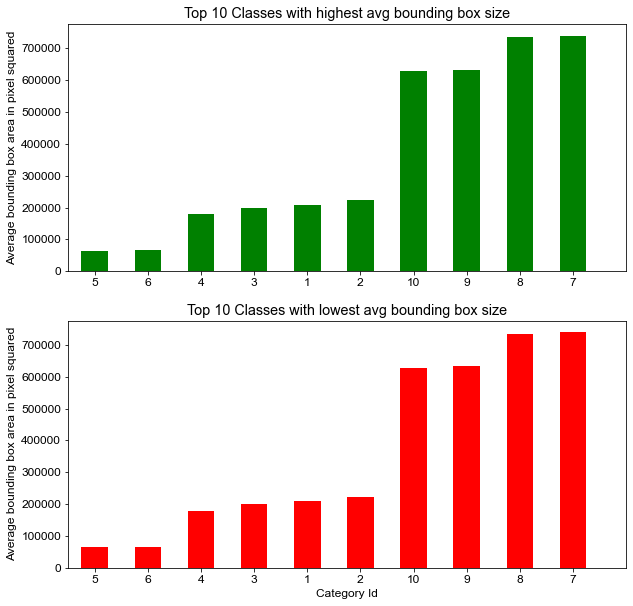

1 -> 001_drink, 2 -> 002_drink, 3 -> 003_chocolate, 4 -> 004_chocolate, 5 -> 005_candy, 6 -> 006_candy, 7 -> 007_puffed_food, 8 -> 008_puffed_food, 9 -> 009_tissue, 10 -> 010_tissue, 

In [11]:
top = min(30, len(bbox_avg_areas))

plt.figure(figsize=(10, 10))

y = [item[1] for item in bbox_avg_areas[-top:]]
x = [item[0] for item in bbox_avg_areas[-top:]]

y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]

plt.subplot(211)
plt.bar(np.arange(len(y)), y, width=0.5, tick_label=x, color='green')
plt.xlim(-0.5, len(y))
# plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top ' + str(top) + ' Classes with highest avg bounding box size')

plt.subplot(212)
plt.bar(np.arange(len(y2)), y2, width=0.5, tick_label=x2, color='red')
plt.xlim(-0.5, len(y2))
plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top ' + str(top) + ' Classes with lowest avg bounding box size')
plt.show()

categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k, '->', categ_map[k], end=", ")

## Viewing random images

Exception: datasetType not supported

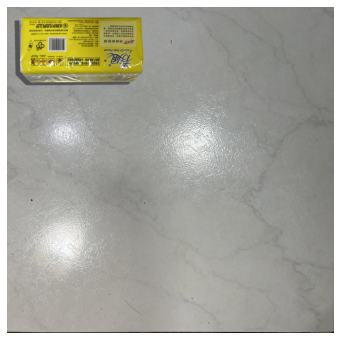

In [13]:
# generate a random image
imgIds = [i['id'] for i in root['images']]
catIds = [i['id'] for i in root['categories']]
img = coco_obj.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
img_path = os.path.join(src_desc, img['file_name'])
I = io.imread(img_path)

# plot annotations
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(I)
annIds = coco_obj.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_obj.loadAnns(annIds)

###  disable segmentation
for a in anns:
    if 'segmentation' in a.keys():
        a['segmentation'] = []
coco_obj.showAnns(anns, draw_bbox=True)
# classes = [categ_map[a['category_id']] for a in anns]
# print(classes)